In [0]:
import tensorflow as tf
tf.enable_eager_execution()
tfe = tf.contrib.eager

from os import listdir
import matplotlib.pyplot as plt
import numpy as np
import time
from PIL import Image
import numpy as np
import cv2
from IPython import display
from tensorflow.python.keras import models
from tensorflow.keras.layers import Conv2D, UpSampling2D, RepeatVector,concatenate

# Colorization: VGG-16 Transfer Learning

This notebook is used to implement the algorithm proposed by [Federico Baldassarre](https://arxiv.org/abs/1712.03400). However, we used VGG16 to extract both high-level and mid-level features in our implementations. 

## Step 0: Read Images

In [0]:
# # Here, upload our zip file!
# !unzip 'VOC110.zip'

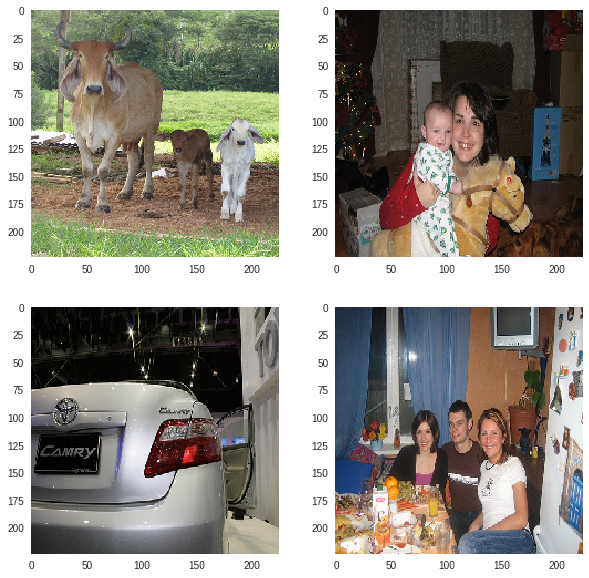

In [3]:
# Read images from folder
height = 224
width  = 224

from os import listdir

def loadImages(path):
  """This function will load images from folder
  
  Arguments:
    path: the folder path
      
  Returns:
    returns a list contains all images
  """
  imagesList = listdir(path)
  loadedImages = []
  for image in imagesList:
    if image[::-1][:4] == '.jpg'[::-1]:
      img = Image.open(path + image)
      img = img.resize((width, height))
      loadedImages.append(img)
  return loadedImages
  
path = "./VOC110/"
source_images = loadImages(path)
n=len(source_images)
# randomly show four images in our dataset
plt.figure(figsize=(10,10))
for j,i in enumerate(np.random.choice(n,4)):
    plt.subplot(2,2,j+1)
    plt.imshow(source_images[i])
    plt.grid(False)

## Step 1: Data Preprocessing

In [4]:
# Get np.array for our source images(LAB)
# 32-bit images should be rescaled to [0,1] before using cvtColor!
# /255 ideas come from: 
# https://docs.opencv.org/3.0-beta/modules/imgproc/doc/miscellaneous_transformations.html
source_array = np.zeros(shape=(n, width, height, 3), dtype='float32')
for i in range(n):
  temp = np.asarray(source_images[i], dtype='float32')/255.
  source_array[i,:,:,:] = cv2.cvtColor(temp, cv2.COLOR_RGB2LAB)
  
print(source_array.shape)

(110, 224, 224, 3)


In [0]:
source_array = source_array[:10,:,:,:]

Then, we have to preprocess source images because the input for VGG16 should be subtracted means vector.

In [0]:
# # Get the input for vgg16
# means = np.mean(source_array, tuple(range(3)),dtype='float32'); print('means: ', means)
# source_array -= means

In [0]:
source_l = np.asarray([source[:,:,0] for source in source_array])
source_ab = np.asarray([source[:,:,1:]/128 for source in source_array])
# print(source_ab)

## Step 2: Extract Features

In [0]:
def encoder_and_fusion(source_l,high_layers,mid_layers):
  vgg16 = tf.keras.applications.vgg16.VGG16(input_shape=(224, 224, 3), include_top=True)
  vgg16.trainable = False
  high_features = [vgg16.get_layer(l).output for l in high_layers] 
  mid_features = [vgg16.get_layer(l).output for l in mid_layers]    
  outputs = high_features + mid_features
  model = models.Model(vgg16.input,outputs)
  source_l = np.repeat(source_l,3).reshape(source_l.shape[0],source_l.shape[1],
                                           source_l.shape[2],3)
  x = model(source_l)
  x_high = x[0]
  x_mid = x[1]
  x = np.repeat(x_high,x[1].shape[1]*x[1].shape[2]).reshape([x_high.shape[0],
                                                               x_mid.shape[1],x_mid.shape[1],x_high.shape[1]])
  x = concatenate([x,x_mid],axis=3)
  return x

In [0]:
high_layers = ['predictions']
mid_layers = ['block3_pool'] #not deep layer!

In [0]:
source_features = encoder_and_fusion(source_l,high_layers,mid_layers)  #1257???

## Step 3: Build Model

In [0]:
class Decoder_Model(tf.keras.Model):
  def __init__(self):
    super(Decoder_Model, self).__init__()
    self.decoder_conv1 = Conv2D(filters=256, kernel_size=(1,1), strides=1, padding="same", activation='relu')
    self.decoder_conv2 = Conv2D(filters=256, kernel_size=(3,3), strides=1, padding="same", activation='relu')
    self.decoder_upsamp1 = UpSampling2D((2,2))
    self.decoder_conv3 = Conv2D(filters=64, kernel_size=(3,3), strides=1, padding="same", activation='relu')
    self.decoder_conv4 = Conv2D(filters=64, kernel_size=(3,3), strides=1, padding="same", activation='relu')
    self.decoder_upsamp2 = UpSampling2D((2,2))
    self.decoder_conv5 = Conv2D(filters=32, kernel_size=(3,3), strides=1, padding="same", activation='relu')
    self.decoder_conv6 = Conv2D(filters=2, kernel_size=(3,3), strides=1, padding="same", activation='tanh') #-1 to 1
    self.decoder_upsamp3 = UpSampling2D((2,2))
  
  def call(self, x):
    #x = tf.reshape(x,(-1,x.shape[0],x.shape[1],x.shape[2]))
    # Decoder Layer
    x = self.decoder_conv1(x)
    x = self.decoder_conv2(x)
    x = self.decoder_upsamp1(x)
    x = self.decoder_conv3(x)
    x = self.decoder_conv4(x)
    x = self.decoder_upsamp2(x)
    x = self.decoder_conv5(x)
    x = self.decoder_conv6(x)
    x = self.decoder_upsamp3(x)
    
    return x

In [0]:
decoder = Decoder_Model()

## Step 3: Compute Loss

In [0]:
def compute_loss(true_ab, pred_ab):
  loss = tf.reduce_sum(tf.square(true_ab-pred_ab))
  norm = tf.cast(2*true_ab.shape[1]*true_ab.shape[2],tf.float32)
  return tf.multiply(norm,loss)

## Step 4: Create Train Operation

In [0]:
opt = tf.train.AdamOptimizer(learning_rate=1e-5)
# single image rate should be 1e-4

In [0]:
def train_step(model,source_features,source_ab):
  
  with tf.GradientTape() as tape:
    
    pred_ab = model(source_features)
    loss = compute_loss(source_ab, pred_ab)

  grads = tape.gradient(loss, model.variables)
  opt.apply_gradients(zip(grads, model.variables))
  #return loss, grads
  return loss

In [0]:
# Compile the training step with defun for increased performance(graph mode)
train_step = tf.contrib.eager.defun(train_step)

## Step 5: Training Process

In [0]:
epochs = 2000

In [0]:
def train_and_display():
  display.clear_output(wait=True)
  pred_ab = decoder(source_features)*128
  imgs=[]
  for i in range(pred_ab.shape[0]):
    ab_hat = np.asarray(pred_ab[i,:,:,:])
    target = cv2.merge([source_l[i,:,:],ab_hat])
    #target += means
    #target = np.clip(target,[0,-128,128],[100,128,128])
    target = cv2.cvtColor(target, cv2.COLOR_LAB2RGB)
    target = np.clip(target,0,255)
    imgs.append(target)
  
  #fig = plt.figure(figsize=(10,10))
  fig =plt.figure(figsize=(20,10))
  for i in range(len(imgs)):  
    plt.subplot(5,(len(imgs)//5)+1, i+1)
    plt.imshow(imgs[i])
    plt.axis('off')
  plt.show()  

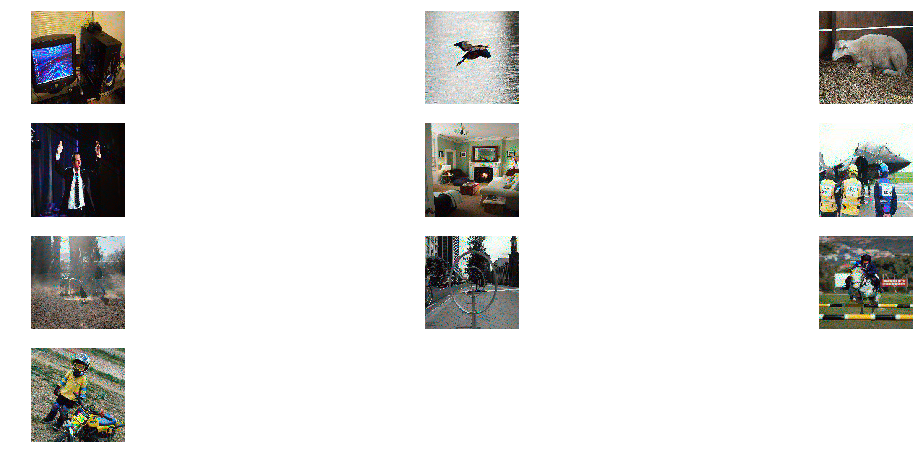

Epoch 999. Seconds 0.16805577278137207
Epoch 999. Total Loss 291349184.0


In [20]:
for epoch in range(epochs):
  start = time.time()
  for i in range(source_features.shape[0]):
    loss = train_step(decoder,np.expand_dims(source_features[i,:,:,:],axis=0),
                             np.expand_dims(source_ab[i,:,:,:],axis=0))
  end = time.time()
  
  train_and_display()
  print ('Epoch {}. Seconds {}'.format(epoch, end - start))
  print ('Epoch {}. Total Loss {}'.format(epoch,loss))
  #print ('Epoch {}. Gradients {}'.format(epoch,grads))

In [0]:
decoder.save_weights('2019_01_24_model.h5')

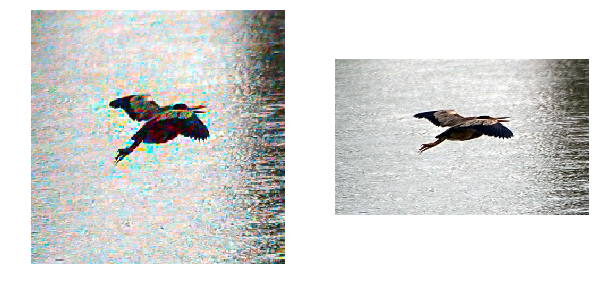

In [49]:
# read data
height = 224
width = 224
test_image = Image.open('test5.jpg')
test_image = test_image.resize((width, height))

# data preprocess
test_array = np.asarray(test_image, dtype='float32')/255.
test_array = cv2.cvtColor(test_array, cv2.COLOR_BGR2LAB)
test_array = np.expand_dims(test_array,axis=0)

# extract features
test_l = np.asarray(test_array[:,:,:,0])
test_ab = np.asarray(test_array[:,:,:,1:]/128)
test_features = encoder_and_fusion(test_l,high_layers,mid_layers)

# predict images
test_pred_ab = decoder(test_features)*128
test_ab_hat = np.asarray(test_pred_ab[0,:,:,:])
img_hat = cv2.merge([test_l[0,:,:],test_ab_hat])
img_hat = cv2.cvtColor(img_hat, cv2.COLOR_LAB2RGB)
img_hat = np.clip(img_hat,0,255)

# show the result
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(img_hat)
plt.grid(False)
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(cv2.imread('test5.jpg',-1), cv2.COLOR_BGR2RGB))
plt.grid(False)
plt.axis('off')
plt.show()
#plt.savefig("test_pred.jpg",bbox_inches='tight')

TODO(1.8): DEBUGGING

* VGG input should be RGB range! (consider it!)
* image inverse preprocess! (why does we get green images always? )
* Middle features layers recheck! (change architecture by ourselves.)
* Open CV convert RGB to LAB relationship! 
* Batch Training.

---

Done(1.24): 
* cv2 convert color space, pay attention to the scale. If we're using 32 float points image, we should divide 255 before converting. 

TODO(1.24): Improvement

* Batch Training.
* Improve the training size and epochs. 
* How to improve the model(Zhang's idea and other ideas). 
* Tuning part: architecture and middle features(which layers?), which model(VGG/Interception?). 
* If we could change the architecture of decoder net. (upsampling stride, kernel size and layers------> change a little bit may become a new model!)